In [20]:
!pip install fal-client

In [24]:
!pip install --upgrade numpy matplotlib

  Using cached numpy-2.2.6-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 6.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0


In [22]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# https://fal.ai/dashboard/keys
# put your key in the .env file with the name FAL_KEY

True

In [16]:
import nest_asyncio
nest_asyncio.apply()

In [17]:
import asyncio
import fal_client

async def generate_images(model: str, prompt: str):
    guidance_scales = [1, 3.5, 6, 8.5]
    inference_steps = [6, 28, 50]
    
    # Submit 12 requests in parallel with different parameters
    handlers = await asyncio.gather(*[
        fal_client.submit_async(
            model,
            arguments={
                "prompt": prompt,
                "guidance_scale": gs,
                "num_inference_steps": steps,
                "seed": 42
            },
        ) 
        for gs in guidance_scales
        for steps in inference_steps
    ])

    # Get all results in parallel
    results = await asyncio.gather(*[
        fal_client.result_async(model, handler.request_id) 
        for handler in handlers
    ])
    
    return results, guidance_scales, inference_steps


# Model and prompt configuration
model = "fal-ai/flux/dev"
prompt = "photo of a rhino dressed suit and tie sitting at a table in a bar with a bar stools, award winning photography, Elke vogelsang"

results, guidance_scales, inference_steps = await generate_images(model, prompt)

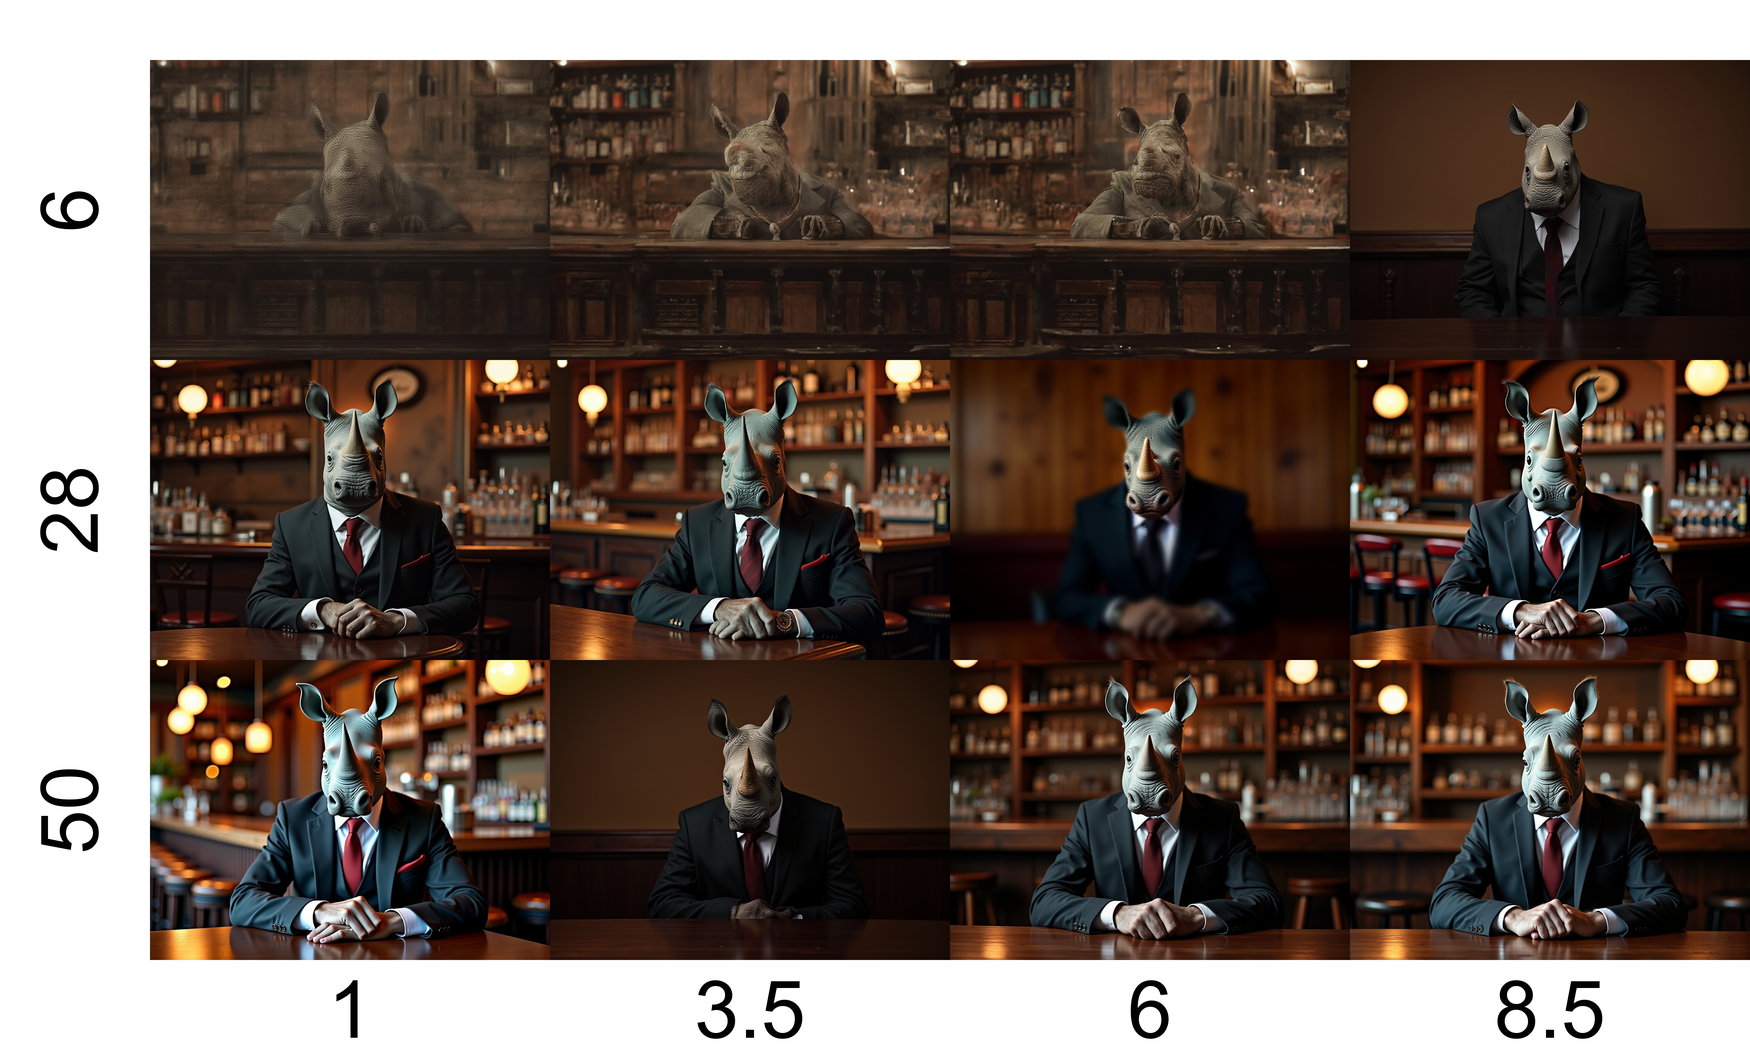

In [27]:
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO

def display_image_grid(results, guidance_scales, inference_steps):
    # Image dimensions
    img_width, img_height = 400, 300
    margin = 150
    
    total_width = img_width * 4 + margin
    total_height = img_height * 3 + margin
    
    # Create a higher resolution image then scale down for anti-aliasing
    scale_factor = 4
    hires_width = total_width * scale_factor
    hires_height = total_height * scale_factor
    
    combined_image = Image.new('RGB', (hires_width, hires_height), 'white')
    draw = ImageDraw.Draw(combined_image)
    
    # Try to get any available font
    font = None
    font_size = 80 * scale_factor  # Large font size for high-res image
    
    # List of font names to try
    font_names = [
        "arial.ttf", "Arial.ttf", "helvetica.ttf", "Helvetica.ttf",
        "DejaVuSans.ttf", "LiberationSans-Regular.ttf", "FreeSans.ttf",
        "Roboto-Regular.ttf", "NotoSans-Regular.ttf"
    ]
    
    # Try to load a font
    for font_name in font_names:
        try:
            font = ImageFont.truetype(font_name, font_size)
            break
        except:
            continue
    
    # If no TrueType font found, use default and scale up
    if font is None:
        font = ImageFont.load_default()
        # We'll draw text at 10x size on the high-res image
        
    # Function to draw text at scale
    def draw_text_scaled(x, y, text, anchor="mm"):
        if font == ImageFont.load_default():
            # For default font, draw multiple times to make it thicker
            for dx in range(-5, 6):
                for dy in range(-5, 6):
                    draw.text((x + dx, y + dy), text, fill='black', anchor=anchor)
        else:
            draw.text((x, y), text, fill='black', font=font, anchor=anchor)
    
    # Add images to grid
    for idx, result in enumerate(results):
        row = idx // 4
        col = idx % 4
        
        # Download image
        image_url = result['images'][0]['url']
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        img = img.resize((img_width * scale_factor, img_height * scale_factor), Image.Resampling.LANCZOS)
        
        # Calculate position
        x = col * img_width * scale_factor + margin * scale_factor
        y = row * img_height * scale_factor + 60 * scale_factor
        combined_image.paste(img, (x, y))
        
        # Add labels
        if row == 2:  # Bottom row
            text = f"{guidance_scales[col]}"
            text_x = x + (img_width * scale_factor) // 2
            text_y = hires_height - 40 * scale_factor
            draw_text_scaled(text_x, text_y, text)
            
        if col == 0:  # Leftmost column
            text = f"{inference_steps[row]}"
            # Create rotated text
            text_img = Image.new('RGB', (400 * scale_factor, 100 * scale_factor), 'white')
            text_draw = ImageDraw.Draw(text_img)
            if font == ImageFont.load_default():
                for dx in range(-5, 6):
                    for dy in range(-5, 6):
                        text_draw.text((200 * scale_factor + dx, 50 * scale_factor + dy), 
                                     text, fill='black', anchor="mm")
            else:
                text_draw.text((200 * scale_factor, 50 * scale_factor), 
                             text, fill='black', font=font, anchor="mm")
            text_img = text_img.rotate(90, expand=True)
            combined_image.paste(text_img, (20 * scale_factor, y + (img_height * scale_factor) // 2 - 200 * scale_factor))
    
    # Scale down the image for display
    final_image = combined_image.resize((total_width, total_height), Image.Resampling.LANCZOS)
    
    # Display
    display(final_image)

# Call the function
display_image_grid(results, guidance_scales, inference_steps)